In [1]:
# import necessary modules
import os
import sys
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import path
import time
import xarray as xr
import xugrid as xu

# Undo below code and specify your folder if you don't run this code under hydromt_sfincs_insider github branch
sys.path.append(os.path.abspath("C:/Intern/SFINCS_Wave/hydromt_sfincs_insiders")) 

from hydromt_sfincs.sfincs import SfincsModel
from hydromt_sfincs import utils
from hydromt.log import setuplog
import hydromt

**1. Model Initialization**
 
1.1. Ensuring updated HydroMT version

In [2]:
!hydromt --version

HydroMT version: 0.10.0


1.2. Initialize SFINCS Model and Connect It with Data Catalog

In [3]:
# Specify root_folder and logger_name
from pathlib import Path
root_folder  = Path('sofala_wave_stockdon')
boundary_folder = Path('boundary_conditions')
logger = setuplog("sfincs_quadtree", log_level=10)

# initialize model
sf_qt = SfincsModel(
    data_libs = ['datacatalog.yml'], 
    root=root_folder, 
    mode="w+", 
    logger=logger
)

2024-11-05 10:14:10,337 - sfincs_quadtree - log - INFO - HydroMT version: 0.10.0
2024-11-05 10:14:10,377 - sfincs_quadtree - data_catalog - INFO - Parsing data catalog from datacatalog.yml
2024-11-05 10:14:10,393 - sfincs_quadtree - log - DEBUG - Appending log messages to file c:\Intern\SFINCS_Wave\COMPASS\SFINCS_Wave\sofala_wave_stockdon\hydromt.log.
2024-11-05 10:14:10,394 - sfincs_quadtree - model_api - INFO - Initializing sfincs model from unknown (vNA).


Rerun below code if you update your data catalog

In [4]:
data_catalog  = hydromt.DataCatalog(data_libs = ['datacatalog.yml'])

**2.Setup Grid, Dep, and Mask**
 
2.1. Import region polygon

In [5]:
epsg = 32736
quadtree_region = gpd.read_file(boundary_folder / 'gis' / 'bbox.gpkg').to_crs(epsg)
quadtree_refinement = gpd.read_file(boundary_folder / 'gis' / 'refinement_emp.gpkg').to_crs(epsg)

gdf_refinement = gpd.GeoDataFrame(
    {"refinement_level": [1]},
    geometry=[
        quadtree_refinement.geometry.iloc[0]
    ],
    crs=f'EPSG:{epsg}'
)

2.2. Making grid

2024-11-05 10:14:10,495 - sfincs_quadtree - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [ 631685.14925612 7714854.0234284   793224.91996494 7881678.64915184] (crs = EPSG:32736)'}
Building mesh ...
Refining ...
Time elapsed : 0.903998613357544 s
Finding neighbors ...
Time elapsed : 0.306002140045166 s
Setting neighbors left and below ...
Time elapsed : 0.6500012874603271 s
Getting uv points ...
Time elapsed : 1.3320038318634033 s
Making XUGrid ...
Got rid of duplicates in 4.6868 seconds
Made XUGrid in 0.0097 seconds
Time elapsed : 10.283018589019775 s


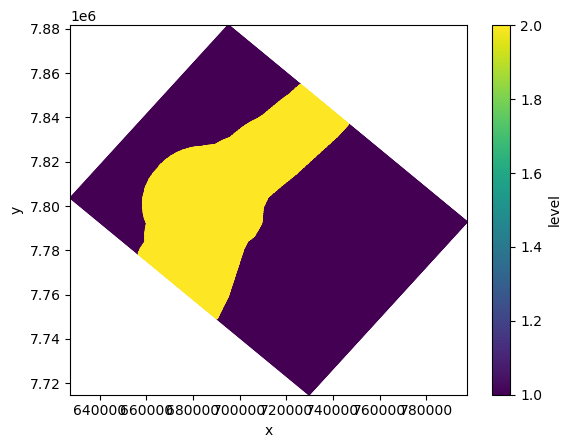

In [6]:
sf_qt.setup_grid_from_region(
    region={"geom": quadtree_region},  
    res=200,  
    rotated=True, 
    refinement_polygons=gdf_refinement,
)


sf_qt.quadtree.data["level"].ugrid.plot()

2.3. Setup dep

In [7]:
datasets_dep = [{'elevtn': 'gebco'}]
sf_qt.setup_dep(datasets_dep=datasets_dep)

2024-11-05 10:14:31,743 - sfincs_quadtree - rasterdataset - INFO - Reading gebco raster data from C:\Intern\SFINCS_Wave\COMPASS\SFINCS_Wave\boundary_conditions\topo\gebco_2024_n-13.0_s-25.0_w30.0_e45.0.nc
2024-11-05 10:14:31,777 - sfincs_quadtree - rasterdataset - WARNING - IO error while detecting zoom levels: Opening a /vsi file with the netCDF driver requires Linux userfaultfd to be available.
2024-11-05 10:14:31,850 - sfincs_quadtree - rasterdataset - DEBUG - Clip to [34.216, -20.653, 35.842, -19.149] (epsg:4326))


2.4. Setup Quadtree Mask and WL Boundary

In [8]:
# Import WL and Empirical Model Mask
emp_wl_bc = gpd.read_file(boundary_folder / 'gis' / 'wavemaker.gpkg').to_crs(epsg)
emp_mask = gpd.read_file(boundary_folder / 'gis' / 'bbox_emp.gpkg').to_crs(epsg)

In [9]:
emp_wl_bc = emp_wl_bc.buffer(2500)
emp_wl_bc = gpd.GeoDataFrame(geometry=emp_wl_bc, crs=f"EPSG:{epsg}")

2024-11-05 10:14:34,263 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [34.258, -20.652, 35.801, -19.149] (EPSG:4326)
2024-11-05 10:14:34,265 - sfincs_quadtree - quadtree - INFO - Building mask ...
2024-11-05 10:14:34,266 - sfincs_quadtree - quadtree - INFO - Build new mask for: sfincs ...
2024-11-05 10:14:39,548 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [34.216, -20.653, 35.842, -19.149] (EPSG:4326)
2024-11-05 10:14:39,555 - sfincs_quadtree - quadtree - DEBUG - waterlevel (mask=2) boundary cells reset.


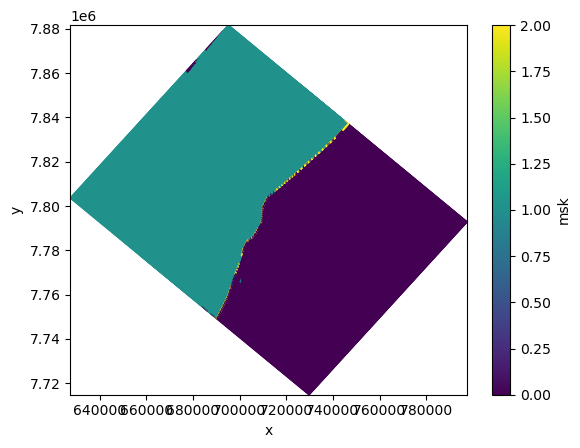

In [10]:
sf_qt.setup_mask_active(
    zmin=-5,
    zmax=111,
    include_mask=emp_mask,
    reset_mask=True
)

sf_qt.setup_mask_bounds(
    btype="waterlevel",
    include_mask=emp_wl_bc,
    zmax=-8,
    zmin=-50,
    reset_bounds=True
)

sf_qt.quadtree.data["msk"].ugrid.plot()

**3. Input Forcing and Specify Observation Points**

3.1. Specify time

In [11]:
# Specify the simulation time in the model config
model_time_config = {
    "tref": "20190301 000000", #FILL IN THE REFERENCE TIME (can be any date)
    "tstart": "20190310 000000", #FILL IN THE START TIME OF THE SIMULATION
    "tstop": "20190316 000000", #FILL IN THE END TIME OF THE SIMULATION
    "dtout": 3600, #FILL IN THE TIMESTEP OF THE MAP OUTPUT
    "dthisout" : 3600, #FILL IN THE TIMESTEP OF THE SCALAR OUTPUT
}

sf_qt.setup_config(**model_time_config)
sf_qt.config["tspinup"] = 3600

2024-11-05 10:14:50,871 - sfincs_quadtree - model_api - DEBUG - Setting model config options.


3.2. Specify WL from DFM and Meteo from ERA5

In [12]:
sf_qt.setup_waterlevel_forcing(
    geodataset='wltot_stockdon',   
    buffer=1000
)

sf_qt.setup_wind_forcing_from_grid(
    wind = 'era5_hourly'
)

sf_qt.setup_pressure_forcing_from_grid(
    press='era5_hourly'
)

2024-11-05 10:14:51,139 - sfincs_quadtree - rasterdataset - INFO - Reading era5_hourly netcdf data from C:\Intern\SFINCS_Wave\COMPASS\SFINCS_Wave\boundary_conditions\meteo\era5_{variable}_2019-03.nc
2024-11-05 10:14:51,181 - sfincs_quadtree - rasterdataset - DEBUG - Slicing time dim (datetime.datetime(2019, 3, 10, 0, 0), datetime.datetime(2019, 3, 16, 0, 0))
2024-11-05 10:14:51,188 - sfincs_quadtree - rasterdataset - DEBUG - Clip to [34.258, -20.652, 35.801, -19.149] (epsg:4326))
2024-11-05 10:14:51,189 - sfincs_quadtree - sfincs - DEBUG - Resample wind using nearest_index.
2024-11-05 10:14:51,463 - sfincs_quadtree - rasterdataset - INFO - Reading era5_hourly netcdf data from C:\Intern\SFINCS_Wave\COMPASS\SFINCS_Wave\boundary_conditions\meteo\era5_{variable}_2019-03.nc
2024-11-05 10:14:51,490 - sfincs_quadtree - rasterdataset - DEBUG - Slicing time dim (datetime.datetime(2019, 3, 10, 0, 0), datetime.datetime(2019, 3, 16, 0, 0))
2024-11-05 10:14:51,496 - sfincs_quadtree - rasterdataset 

3.3. Specify SPW Input

In [13]:
# Specify spw file location
spw_dir = boundary_folder / 'spw'
spw_filename =  "cyclone_option_norain.spw"

# Copy spw file to root folder
source_path = Path(spw_dir) / spw_filename
destination_path = root_folder / spw_filename
shutil.copy(source_path, destination_path)
print(f"File copied to: {destination_path}")

# Modify sfincs.inp to include spw
sf_qt.config["spwfile"] = spw_filename
sf_qt.config["utmzone"] = '36s'

File copied to: sofala_wave_stockdon\cyclone_option_norain.spw


dict_keys(['bzs', 'wind10_u', 'wind10_v', 'press_2d'])


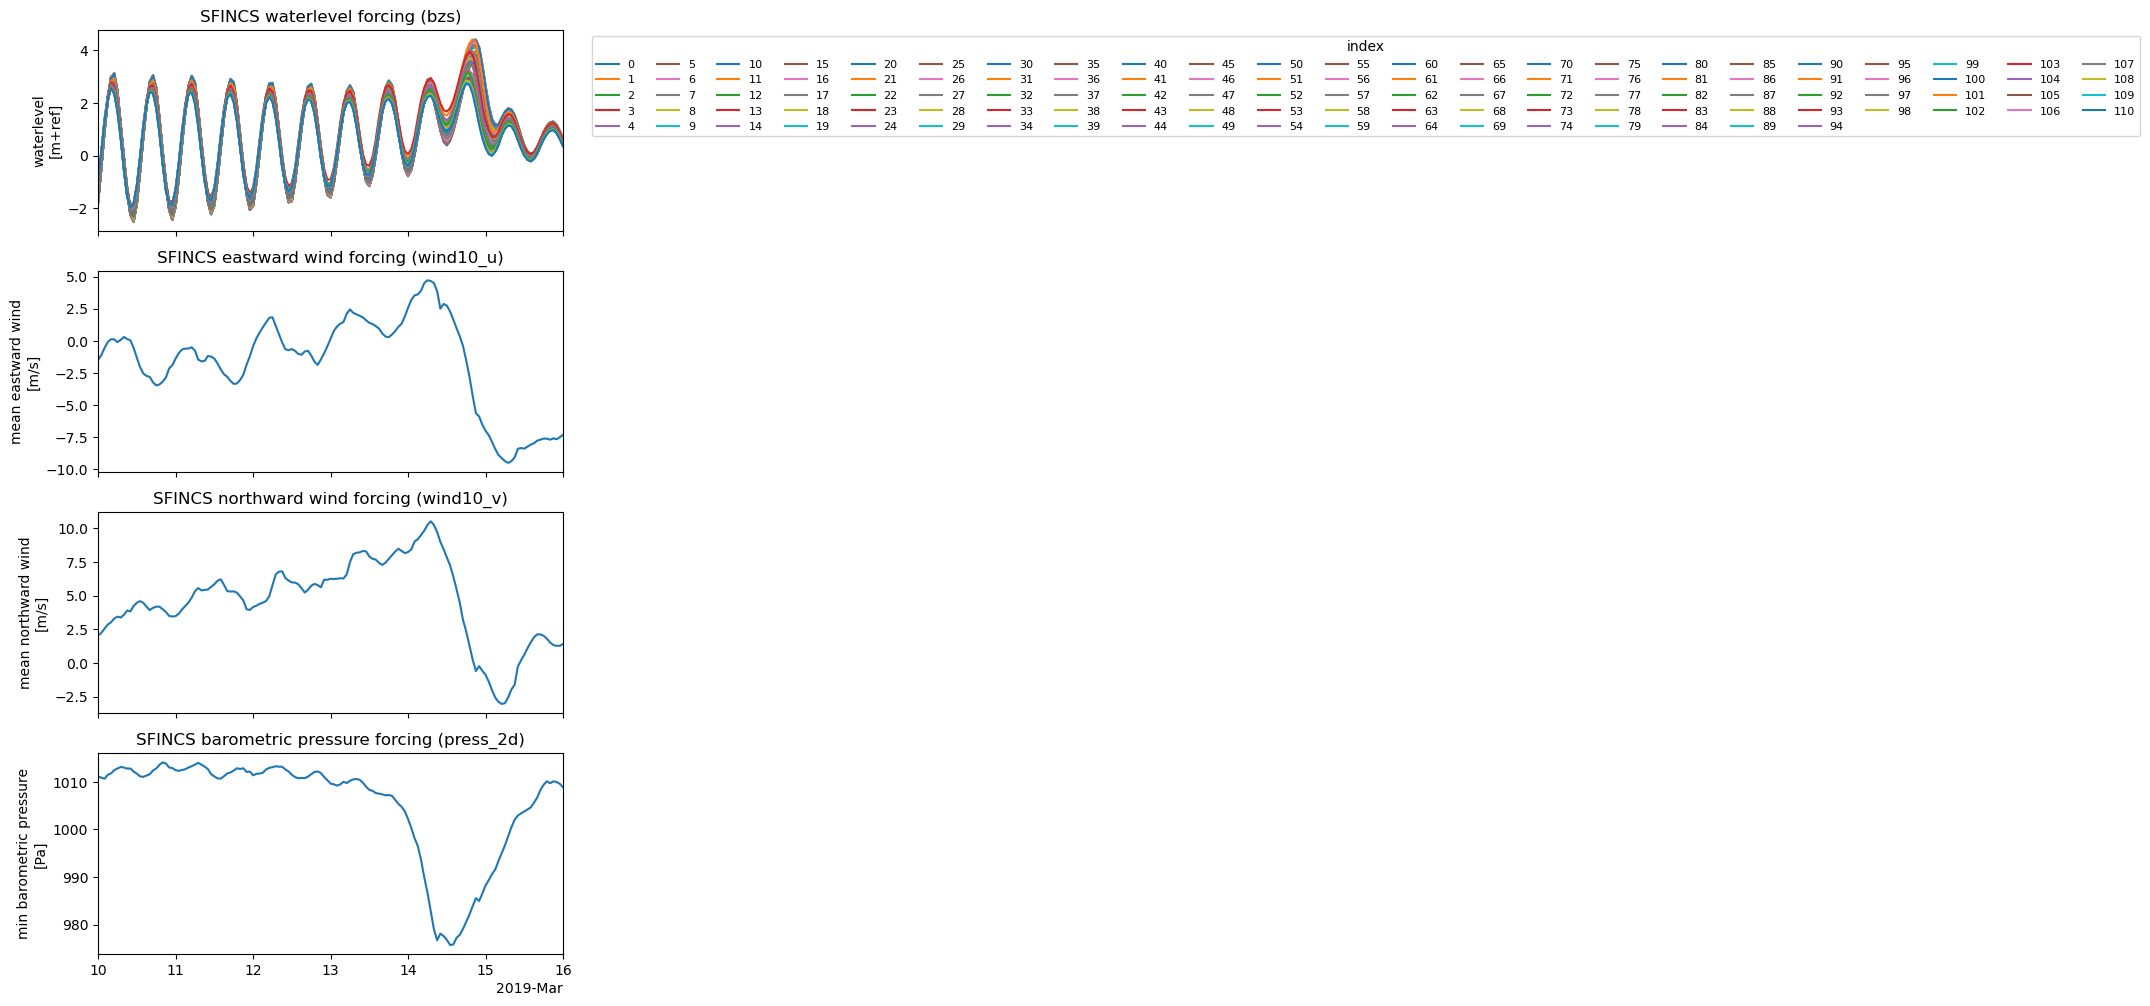

In [14]:
# The keys to access the model forcing
print(sf_qt.forcing.keys())

# # Plot the forcing
_ = sf_qt.plot_forcing()

**4. Finalization and Run SFINCS**

4.1. Setup Obs Point

In [15]:
# Path to observation points & lines geometries
obs_points_fn = boundary_folder / "gis" / 'obs.geojson'

# Setup observation. merge argument handles whether to override or not
sf_qt.setup_observation_points(locations=obs_points_fn, merge=False)

# Print the keys to access the observation geometries
sf_qt.geoms.keys()

2024-11-05 10:14:54,929 - sfincs_quadtree - geodataframe - INFO - Reading  vector data from boundary_conditions\gis\obs.geojson
2024-11-05 10:14:54,945 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [631685.149, 7714854.023, 793224.920, 7881678.649] (EPSG:32736)


dict_keys(['region', 'obs'])

4.2. Write Model

In [16]:
sf_qt.write()

2024-11-05 10:14:54,969 - sfincs_quadtree - sfincs - INFO - Writing model data to c:\Intern\SFINCS_Wave\COMPASS\SFINCS_Wave\sofala_wave_stockdon
2024-11-05 10:14:55,180 - sfincs_quadtree - sfincs - INFO - Write geom files
2024-11-05 10:14:55,189 - sfincs_quadtree - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2024-11-05 10:14:55,201 - sfincs_quadtree - sfincs - INFO - Write forcing files
2024-11-05 10:14:55,234 - sfincs_quadtree - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2024-11-05 10:14:55,711 - sfincs_quadtree - sfincs - WARNING - zsini not in states, skipping


In [17]:
def print_directory_tree(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 2 * (level + 1)
        for f in files:
            print(f'{subindent}+ {f}')

print_directory_tree(sf_qt.root)

sofala_wave_stockdon/
  + cyclone_option_norain.spw
  + hydromt.log
  + hydromt_data.yml
  + press_2d.nc
  + run.bat
  + sfincs.bnd
  + sfincs.bzs
  + sfincs.inp
  + sfincs.nc
  + sfincs.obs
  + wind_2d.nc
  gis/
    + bnd.geojson
    + obs.geojson
    + region.geojson


4.3. Run SFINCS

In [ ]:
cur_dir = os.getcwd()

# # uncomment to run sfincs
os.chdir(root_folder)
os.system("run.bat")
os.chdir(cur_dir)

In [ ]:
import xugrid as xu

uds = xu.open_dataset(root_folder / "sfincs_map.nc")

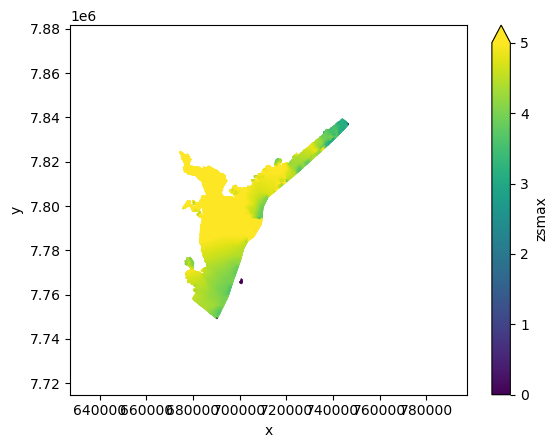

In [ ]:
zsmax = uds["zsmax"].max(dim="timemax")
# plot rough estimation of water depth

zsmax.ugrid.plot(vmax=5)

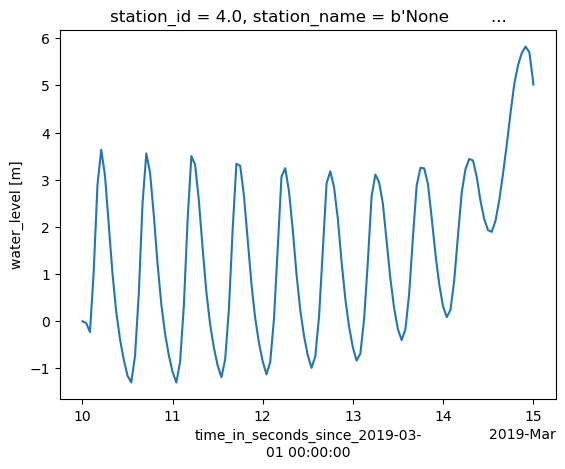

In [ ]:
uds_point = xu.open_dataset(root_folder / "sfincs_his.nc")

id = 3 # first observation point
uds_point['point_zs'][:,id].plot.line(x='time')